In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt
from PIL import Image

In [2]:
import torch
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode

from torch import nn
from torchvision import transforms

## Dataset

In [10]:
!wget https://archive.org/download/real-and-fake-face-detection/real-and-fake-face-detection.zip
!unzip real-and-fake-face-detection.zip

--2024-10-02 16:19:25--  https://archive.org/download/real-and-fake-face-detection/real-and-fake-face-detection.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801004.us.archive.org/28/items/real-and-fake-face-detection/real-and-fake-face-detection.zip [following]
--2024-10-02 16:19:30--  https://ia801004.us.archive.org/28/items/real-and-fake-face-detection/real-and-fake-face-detection.zip
Resolving ia801004.us.archive.org (ia801004.us.archive.org)... 207.241.228.84
Connecting to ia801004.us.archive.org (ia801004.us.archive.org)|207.241.228.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225897402 (215M) [application/zip]
Saving to: 'real-and-fake-face-detection.zip'

real-and-fake-face- 100%[===================>] 215.43M  5.88MB/s    in 38s     

2024-10-02 16:20:09 (5.64 MB/s) - 'real-and-fake-face-detecti

In [4]:
# study data
"""
difficulty_serial_lefteye_righteye_nose_mouth
easy_143_0011

0=original
1=manipulated

""";

In [11]:
fake_images = !ls "real_and_fake_face/training_fake/"
real_images = !ls "real_and_fake_face/training_real/"

In [13]:
all_images = fake_images + real_images
all_images[:20]

['easy_100_1111.jpg',
 'easy_101_0010.jpg',
 'easy_102_0101.jpg',
 'easy_103_1111.jpg',
 'easy_104_1000.jpg',
 'easy_105_1100.jpg',
 'easy_106_0011.jpg',
 'easy_107_1011.jpg',
 'easy_108_1111.jpg',
 'easy_109_1111.jpg',
 'easy_10_0001.jpg',
 'easy_110_0001.jpg',
 'easy_111_1101.jpg',
 'easy_112_1001.jpg',
 'easy_113_0011.jpg',
 'easy_114_1110.jpg',
 'easy_115_0010.jpg',
 'easy_116_111.jpg',
 'easy_117_0101.jpg',
 'easy_118_1111.jpg']

In [14]:
df = pd.DataFrame({"image":all_images})

df['label'] = df['image'].str.split("_").apply(lambda x : x[0])

# get the manipulated_parts
fake_index = df[df['label'] !='real'].index
df['manipulated_part'] = ""

df.loc[fake_index, 'manipulated_part']= \
    df.iloc[fake_index]['image'].str.split("_").apply(lambda x : x[2].split('.')[0])

In [15]:
df.loc[fake_index, 'imagepath'] = "real_and_fake_face/training_fake/" + df.iloc[fake_index]['image']

real_index = df[df['label']=='real'].index
df.loc[real_index, 'imagepath'] = "real_and_fake_face/training_real/" + df.iloc[real_index]['image']

df['real'] = df['label']=='real'

label               real
manipulated_part        
Name: 1408, dtype: object


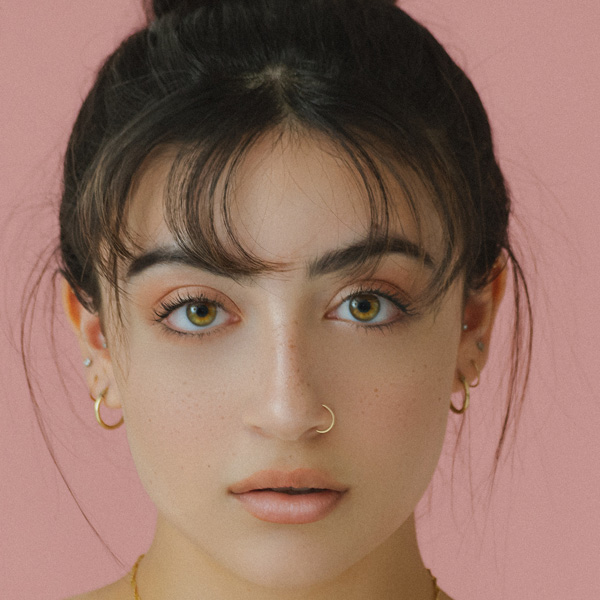

In [16]:
randindex = np.random.randint(0, high=len(df))
image=Image.open(df['imagepath'].iloc[randindex])
print(df[['label', 'manipulated_part']].iloc[randindex])
image

In [17]:
df['real'].value_counts()

real
True     1081
False     960
Name: count, dtype: int64

## Splitting dataset

In [18]:
from sklearn.model_selection import train_test_split

# stratify split data
RANDOM_STATE=42
train_idx, valid_idx= train_test_split(np.arange(len(df)), test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=df['real'])

len(train_idx), len(valid_idx)

(1632, 409)

## CustomImageDataset

In [19]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'imagepath']
        image = read_image(img_path, mode=ImageReadMode.RGB)
        
        label = self.dataframe.loc[idx, 'real']
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [20]:
train_split = df.iloc[train_idx, :].reset_index()
valid_split = df.iloc[valid_idx, :].reset_index()

traindataset = CustomImageDataset(train_split)
validdataset = CustomImageDataset(valid_split)

train_dataloader = DataLoader(traindataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(validdataset, batch_size=16, shuffle=False)

## Define Model

In [21]:
def create_effnetb2_model(num_classes:int=1, seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

## Import training modules
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py

In [22]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model(X).squeeze()

        # 2. Calculate  and accumulate loss
#         print(f"y_logits: {y_logits} | y : {y}")
        loss = loss_fn(y_logits, y.to(torch.float))
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
#         y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
#         y_pred_class = torch.argmax(y_pred, dim=1)
        y_pred = torch.round(torch.sigmoid(y_logits))
        train_acc += (y_pred == y).sum().item()/len(y_logits)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X).squeeze()

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y.to(torch.float))
            test_loss += loss.item()

            # Calculate and accumulate accuracy
#             test_pred_labels = test_pred_logits.argmax(dim=1)
            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [23]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Init model, preprocessing, dataloaders

In [31]:
LEARNING_RATE = 0.001

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=1, seed=42)

# Set loss and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(effnetb2.parameters(),
                             lr=LEARNING_RATE)

In [32]:
traindataset = CustomImageDataset(train_split, transform=effnetb2_transforms)
validdataset = CustomImageDataset(valid_split, transform=effnetb2_transforms)

BATCH_SIZE = 32
train_dataloader = DataLoader(traindataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)


valid_dataloader = DataLoader(validdataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False)

## Training

In [33]:
EPOCHS=100

train_results = train(model= effnetb2, 
                      train_dataloader=train_dataloader, 
                      test_dataloader=valid_dataloader, 
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=EPOCHS,
                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6825 | train_acc: 0.5441 | test_loss: nan | test_acc: 0.6522
Epoch: 2 | train_loss: 0.6502 | train_acc: 0.6452 | test_loss: 0.6564 | test_acc: 0.6213
Epoch: 3 | train_loss: 0.6255 | train_acc: 0.6612 | test_loss: 0.6468 | test_acc: 0.6268
Epoch: 4 | train_loss: 0.6134 | train_acc: 0.6801 | test_loss: 0.6425 | test_acc: 0.6286
Epoch: 5 | train_loss: 0.6067 | train_acc: 0.6783 | test_loss: 0.6371 | test_acc: 0.6220
Epoch: 6 | train_loss: 0.5994 | train_acc: 0.6789 | test_loss: 0.6328 | test_acc: 0.6471
Epoch: 7 | train_loss: 0.5777 | train_acc: 0.7132 | test_loss: 0.6336 | test_acc: 0.6392
Epoch: 8 | train_loss: 0.5866 | train_acc: 0.6949 | test_loss: 0.6361 | test_acc: 0.6371
Epoch: 9 | train_loss: 0.5722 | train_acc: 0.7108 | test_loss: 0.6332 | test_acc: 0.6358
Epoch: 10 | train_loss: 0.5682 | train_acc: 0.7047 | test_loss: 0.6340 | test_acc: 0.6340
Epoch: 11 | train_loss: 0.5656 | train_acc: 0.7096 | test_loss: 0.6321 | test_acc: 0.6437
Epoch: 12 | train_loss

## Training results

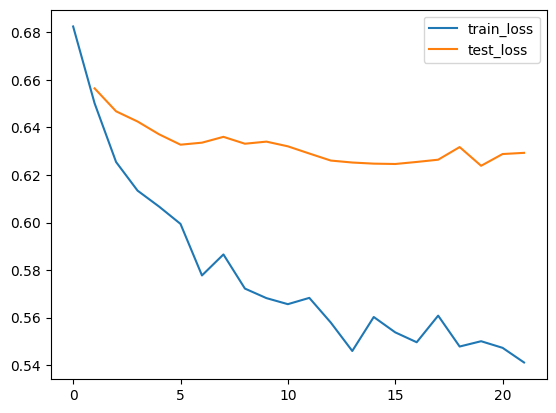

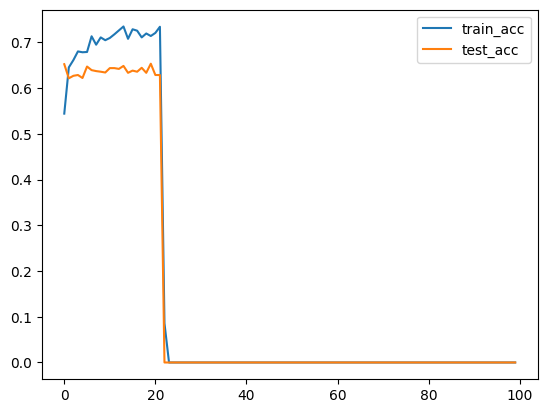

In [34]:
train_results = pd.DataFrame(train_results)

train_results[['train_loss', 'test_loss']].plot();
train_results[['train_acc', 'test_acc']].plot();

In [2]:
effnetb2

NameError: name 'effnetb2' is not defined